# 딥러닝 기반 이미지 분류를 활용한 분리수거 자동 분류 시스템

EfficientNetB0 모델 성능 평가
문제 정의

---

환경부 조사에 따르면 우리나라 국민 한 사람이 70년간 배출하는 생활 쓰레기는 무려 55톤에 달 한다고 한다. <br>
사람들의 구매 욕구와 생활의 편의로 생활 쓰레기는 급격하게 증가하고 있으며,
이에 따라 여러 가지 환경 문제가 발생 하고 있다. <br>
이러한 상황에서 올바른 재활용 분리 배출은 문제 해결의 첫 걸음이 될 수 있을 뿐만 아니라 지속 가능한 자원 순환의 시작이 될 것이다. <br>
하지만 잘못 분리 배출된 재활용 쓰레기는 재사용 이 불가능하고, 이를 처리하는 데 더 많은 비용이 발생한다.<br>
인공 지능을 활용하여 효율적으로 분리수거를 할 수는 없을까?
---

재활용품 이미지 데이터를 분석하고 학습한 후, 효율적으로 재활용품을 분리할 수 있는 인공 지능 모델을 만들고 프로토타입을 구현해 보기


## 1.라이브러리 설치 및 임포트

In [1]:
!pip install koreanize-matplotlib

In [2]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt
import koreanize_matplotlib
import os

import warnings
warnings.filterwarnings('ignore')

## 2.데이터 업로드(구글 드라이브 이미지 폴더 업로드 필요)

In [3]:
#구글 드라이브 연동

path= '/content/drive/MyDrive/abc부트캠프/machine learning/3_0716_cnn/2조'



## 3.데이터셋 로딩

In [4]:


img_size = (160, 160)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)


Found 884 files belonging to 7 classes.
Using 619 files for training.
Found 884 files belonging to 7 classes.
Using 265 files for validation.


##4.데이터 확인

In [5]:
class_names = train_ds.class_names
print("클래스:", class_names)

클래스: ['can', 'general', 'glass', 'paper', 'plastic', 'plastic_bag', 'styrofoam']


In [6]:
# 클래스별 이미지 수 확인
for class_folder in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_folder)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        print(f'{class_folder}: {count}장')

can: 158장
general: 102장
glass: 149장
paper: 127장
plastic: 143장
plastic_bag: 114장
styrofoam: 301장


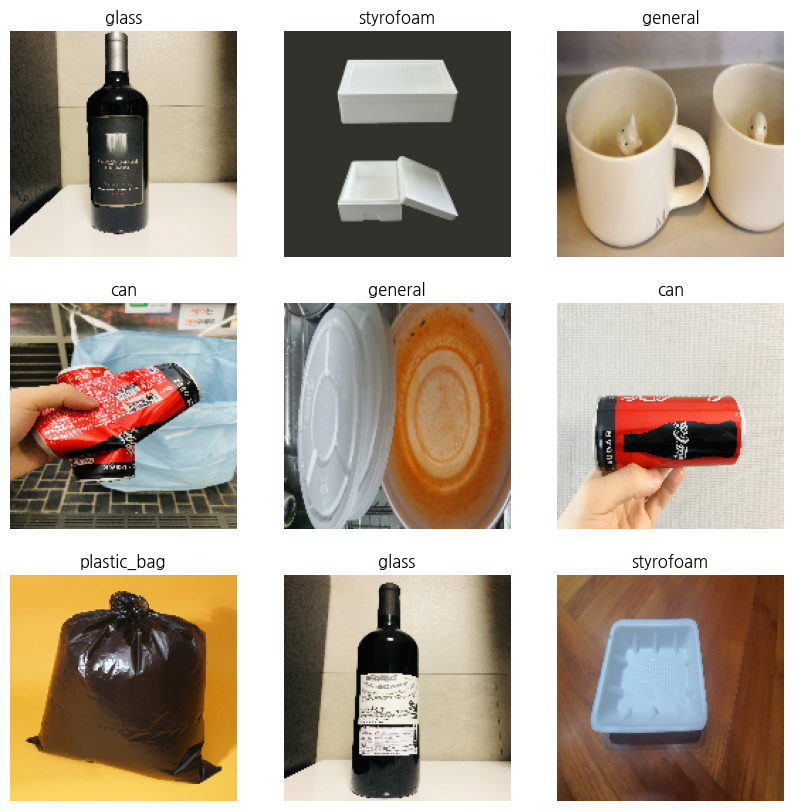

In [7]:
# 샘플 이미지 몇 장 확인
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
    for i in range(9):  # 9장 표시
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


##5.성능 향상을 위한 전처리

In [8]:
# AUTOTUNE: TensorFlow가 자동으로 최적의 prefetch buffer size를 결정해 줌
AUTOTUNE = tf.data.AUTOTUNE

# 학습 데이터셋 처리
train_ds = (
    train_ds
    .cache()                      # 첫 epoch 동안 데이터를 메모리에 저장 → 이후 epoch에서 빠르게 불러오기 (속도 향상)
    .shuffle(100)                 # 데이터 순서를 랜덤하게 섞기 → 과적합 방지, 일반화 성능 향상
    .prefetch(buffer_size=AUTOTUNE)  # CPU가 데이터를 미리 준비 → GPU 학습이 끊기지 않고 연속 처리 가능 (속도 향상)
)

# 검증 데이터셋 처리 (shuffle 불필요)
val_ds = (
    val_ds
    .cache()                      # 검증 데이터도 메모리에 저장하여 빠르게 처리
    .prefetch(buffer_size=AUTOTUNE)  # 학습과 동시에 다음 batch를 준비 (속도 향상)
)


##6.EfficientNetB0 모델 구성 및 학습

### 6-1 EfficientNetB0 모델 구성

In [9]:
class_names

['can', 'general', 'glass', 'paper', 'plastic', 'plastic_bag', 'styrofoam']

In [10]:
# EfficientNetB0 모델 정의
base_model_effnet = tf.keras.applications.EfficientNetB5(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model_effnet.trainable = False  # 전이학습 freeze

model_effnet = models.Sequential([
    base_model_effnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')  #스케일링 후 점수가 가장 큰 수를 더 크게 만들어 구분을 명확하게 만듦
])

### 6-2 EfficientNetB0모델 설정

In [11]:
# 모델 컴파일
model_effnet.compile(
    optimizer='RMSprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### 6-3 EfficientNetB0 모델 학습

In [12]:
# 모델 학습
history_effnet = model_effnet.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.4789 - loss: 1.4639 - val_accuracy: 0.7736 - val_loss: 0.8373
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8352 - loss: 0.6754 - val_accuracy: 0.8340 - val_loss: 0.5913
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.8930 - loss: 0.4801 - val_accuracy: 0.8755 - val_loss: 0.4722
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9292 - loss: 0.3664 - val_accuracy: 0.8792 - val_loss: 0.4048
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9298 - loss: 0.2994 - val_accuracy: 0.8981 - val_loss: 0.3632
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9638 - loss: 0.2372 - val_accuracy: 0.8981 - val_loss: 0.3379
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9674 - loss: 0.1799 - val_accuracy: 0.9132 - val_loss: 0.3219
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9577 - loss: 0.1815 - val_accuracy: 0.8943 

##7.EfficientNetB0 모델 학습 결과 시각화 및 모델 성능평가


### 7-1 학습 결과 시각화
*스윗스팟 찾기

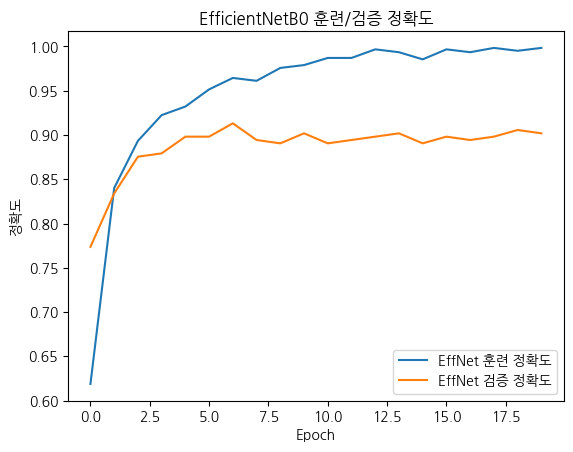

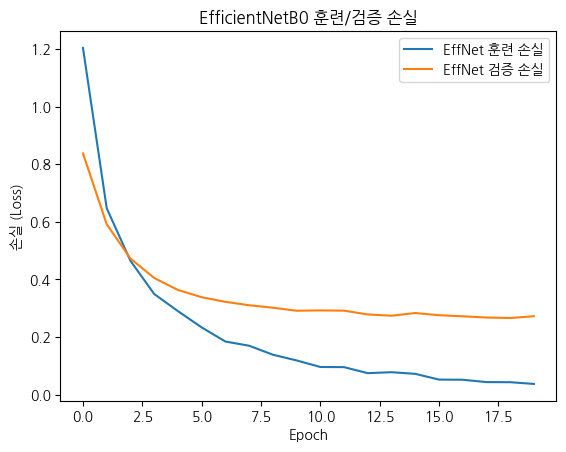

In [13]:
# 정확도 그래프
plt.plot(history_effnet.history['accuracy'], label='EffNet 훈련 정확도')
plt.plot(history_effnet.history['val_accuracy'], label='EffNet 검증 정확도')
plt.xlabel('Epoch')
plt.ylabel('정확도')
plt.legend(loc='lower right')
plt.title('EfficientNetB0 훈련/검증 정확도')
plt.show()

# 손실 그래프
plt.plot(history_effnet.history['loss'], label='EffNet 훈련 손실')
plt.plot(history_effnet.history['val_loss'], label='EffNet 검증 손실')
plt.xlabel('Epoch')
plt.ylabel('손실 (Loss)')
plt.legend(loc='upper right')
plt.title('EfficientNetB0 훈련/검증 손실')
plt.show()

###7-2 Confusion Matrix 성능 평가

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


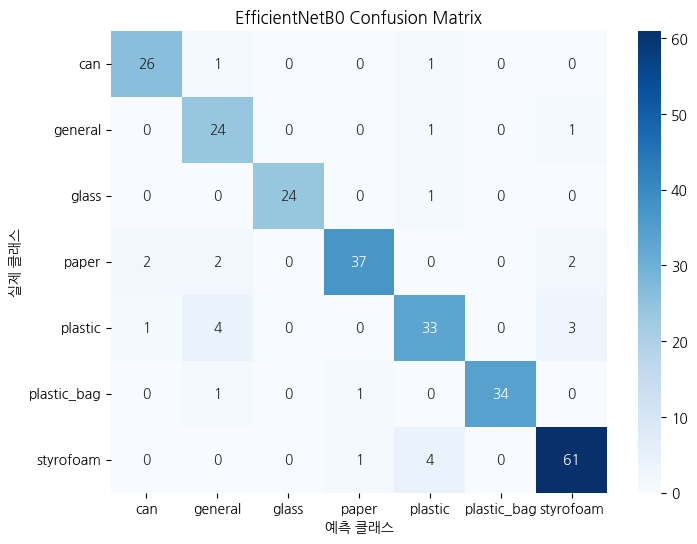

In [14]:
# EfficientNetB0 성능 평가용
y_true_effnet = []
y_pred_effnet = []

# 전체 validation 데이터셋 예측
for images, labels in val_ds:
    preds = model_effnet.predict(images)
    y_true_effnet.extend(labels.numpy())
    y_pred_effnet.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm_effnet = confusion_matrix(
    y_true_effnet,
    y_pred_effnet,
    labels=range(len(class_names))  # 수정 포인트!
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_effnet, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('실제 클래스')
plt.xlabel('예측 클래스')
plt.title('EfficientNetB0 Confusion Matrix')
plt.show()

###7-3 recision / Recall / F1-Score 계산

In [15]:
# Precision / Recall / F1-score 출력
report_effnet = classification_report(
    y_true_effnet,
    y_pred_effnet,
    labels=range(len(class_names)),  # 여기도 잘 들어가 있음!
    target_names=class_names
)
print("=== EfficientNetB0 Precision / Recall / F1-Score ===")
print(report_effnet)

=== EfficientNetB0 Precision / Recall / F1-Score ===
              precision    recall  f1-score   support

         can       0.90      0.93      0.91        28
     general       0.75      0.92      0.83        26
       glass       1.00      0.96      0.98        25
       paper       0.95      0.86      0.90        43
     plastic       0.82      0.80      0.81        41
 plastic_bag       1.00      0.94      0.97        36
   styrofoam       0.91      0.92      0.92        66

    accuracy                           0.90       265
   macro avg       0.90      0.91      0.90       265
weighted avg       0.91      0.90      0.90       265



##8. 이미지로 예측하기

In [16]:
# # 📌 이미지 경로 설정 (Colab에서 직접 업로드)
# from google.colab import files
# uploaded = files.upload()  # 이미지 1장 업로드 (.jpg, .png 등)

# # 파일명 가져오기
# import os
# uploaded_filename = list(uploaded.keys())[0]

# # 이미지 불러오기
# img = image.load_img(uploaded_filename, target_size=img_size)
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가


# # 예측
# preds = model_effnet.predict(img_array)
# print('preds :', preds)
# pred_class_index = np.argmax(preds, axis=1)[0]
# pred_class_name = class_names[pred_class_index]

# # 결과 출력
# plt.imshow(img)
# plt.axis('off')
# plt.title(f'예측 결과: {pred_class_name}')
# plt.show()

# # 만약 한글 매핑 적용하려면 (예시)
# class_name_to_kor = {
#     'can': '캔',
#     'general': '일반쓰레기',
#     'glass': '유리',
#     'paper': '종이',
#     'plastic': '플라스틱',
#     'plastic_bag': '비닐류',
#     'styrofoam': '스티로폼'
# }
# print(f'예측 클래스: {pred_class_name} ({class_name_to_kor.get(pred_class_name, pred_class_name)})')

# for i, score in enumerate(preds[0]):
#     print(f'{class_names[i]}: {score:.4f}')

## 9.모델 저장하기

In [17]:
#model_effnet.save('model_effnetB0.h5')